In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pickle
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')

In [3]:
def rmse(y_pred, y_test):
    return mean_squared_error(y_pred, y_test, squared=False)

In [4]:
tf.random.set_seed(7)

In [23]:
df = pd.read_csv('google.csv')

In [24]:
df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2004-08-19,51.835709,47.800831,49.813290,49.982655,44871361.0,49.982655
1,2004-08-20,54.336334,50.062355,50.316402,53.952770,22942874.0,53.952770
2,2004-08-23,56.528118,54.321388,55.168217,54.495735,18342897.0,54.495735
3,2004-08-24,55.591629,51.591621,55.412300,52.239197,15319808.0,52.239197
4,2004-08-25,53.798351,51.746044,52.284027,52.802086,9232276.0,52.802086
...,...,...,...,...,...,...,...
4312,2021-10-05,2747.239990,2680.000000,2680.000000,2723.540039,1206300.0,2723.540039
4313,2021-10-06,2757.040039,2689.729980,2692.510010,2747.080078,988200.0,2747.080078
4314,2021-10-07,2803.089111,2771.260010,2777.260010,2783.709961,912500.0,2783.709961
4315,2021-10-08,2806.340088,2788.586914,2798.120117,2801.120117,946200.0,2801.120117


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4317 entries, 0 to 4316
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4317 non-null   object 
 1   High       4317 non-null   float64
 2   Low        4317 non-null   float64
 3   Open       4317 non-null   float64
 4   Close      4317 non-null   float64
 5   Volume     4317 non-null   float64
 6   Adj Close  4317 non-null   float64
dtypes: float64(6), object(1)
memory usage: 236.2+ KB


In [26]:
df = df.set_index('Date')
df = df.sort_index()
df.index = pd.DatetimeIndex(df.index)
df = df.reindex(index=pd.date_range(start='2004-08-19', end='2021-10-11'), method='nearest')

In [27]:
df_ = df.copy()
scaler = MinMaxScaler(feature_range=(0,1))
for col in df.columns:
    df_[col] = scaler.fit_transform(df[col].to_numpy().reshape(-1,1))

In [13]:
def create_train_and_test(data, look_back=1):
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    training_len = int(len(data) * 0.8)
    
    train_data = data[:training_len]
    test_data = data[training_len-look_back:]
    
    for i in range(look_back, len(train_data)):
        x_train.append(train_data[i-look_back:i])
        y_train.append(train_data[i])
        
    for i in range(look_back, len(test_data)):
        x_test.append(test_data[i-look_back:i])
    
    y_test = data[training_len:]
        
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [14]:
high_trainX, high_trainy, high_testX, high_testy = create_train_and_test(df_['High'].to_numpy(), look_back=60)
low_trainX, low_trainy, low_testX, low_testy = create_train_and_test(df_['Low'].to_numpy(), look_back=60)
open_trainX, open_trainy, open_testX, open_testy = create_train_and_test(df_['Open'].to_numpy(), look_back=60)
close_trainX, close_trainy, close_testX, close_testy = create_train_and_test(df_['Close'].to_numpy(), look_back=60)
volume_trainX, volume_trainy, volume_testX, volume_testy = create_train_and_test(df_['Volume'].to_numpy(), look_back=60)
adj_close_trainX, adj_close_trainy, adj_close_testX, adj_close_testy = create_train_and_test(df_['Adj Close'].to_numpy(), look_back=60)

In [15]:
# Reshape the data
high_trainX = np.reshape(high_trainX, (high_trainX.shape[0], high_trainX.shape[1], 1))
low_trainX = np.reshape(low_trainX, (low_trainX.shape[0], low_trainX.shape[1], 1))
open_trainX = np.reshape(open_trainX, (open_trainX.shape[0], open_trainX.shape[1], 1))
close_trainX = np.reshape(close_trainX, (close_trainX.shape[0], close_trainX.shape[1], 1))
volume_trainX = np.reshape(volume_trainX, (volume_trainX.shape[0], volume_trainX.shape[1], 1))
adj_close_trainX = np.reshape(adj_close_trainX, (adj_close_trainX.shape[0], adj_close_trainX.shape[1], 1))

In [16]:
# Reshape the data
high_testX = np.reshape(high_testX, (high_testX.shape[0], high_testX.shape[1], 1))
low_testX = np.reshape(low_testX, (low_testX.shape[0], low_testX.shape[1], 1))
open_testX = np.reshape(open_testX, (open_testX.shape[0], open_testX.shape[1], 1))
close_testX = np.reshape(close_testX, (close_testX.shape[0], close_testX.shape[1], 1))
volume_testX = np.reshape(volume_testX, (volume_testX.shape[0], volume_testX.shape[1], 1))
adj_close_testX = np.reshape(adj_close_testX, (adj_close_testX.shape[0], adj_close_testX.shape[1], 1))

In [65]:
## Build the LSTM Model
look_back = 60
EPOCHS = 200

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(high_trainX, high_trainy, epochs=EPOCHS, batch_size=1, verbose=2)

Epoch 1/200
4950/4950 - 85s - loss: 1.2346e-04 - 85s/epoch - 17ms/step
Epoch 2/200
4950/4950 - 83s - loss: 5.9186e-05 - 83s/epoch - 17ms/step
Epoch 3/200
4950/4950 - 83s - loss: 4.0599e-05 - 83s/epoch - 17ms/step
Epoch 4/200
4950/4950 - 83s - loss: 2.4636e-05 - 83s/epoch - 17ms/step
Epoch 5/200
4950/4950 - 85s - loss: 2.2864e-05 - 85s/epoch - 17ms/step
Epoch 6/200
4950/4950 - 83s - loss: 2.1855e-05 - 83s/epoch - 17ms/step
Epoch 7/200
4950/4950 - 82s - loss: 1.9812e-05 - 82s/epoch - 17ms/step
Epoch 8/200
4950/4950 - 82s - loss: 1.5655e-05 - 82s/epoch - 17ms/step
Epoch 9/200
4950/4950 - 82s - loss: 1.7114e-05 - 82s/epoch - 17ms/step
Epoch 10/200
4950/4950 - 82s - loss: 1.2924e-05 - 82s/epoch - 17ms/step
Epoch 11/200
4950/4950 - 83s - loss: 1.5268e-05 - 83s/epoch - 17ms/step
Epoch 12/200
4950/4950 - 82s - loss: 1.2854e-05 - 82s/epoch - 17ms/step
Epoch 13/200
4950/4950 - 82s - loss: 1.2637e-05 - 82s/epoch - 17ms/step
Epoch 14/200
4950/4950 - 82s - loss: 1.3767e-05 - 82s/epoch - 17ms/step
E

Epoch 115/200
4950/4950 - 78s - loss: 6.7167e-06 - 78s/epoch - 16ms/step
Epoch 116/200
4950/4950 - 79s - loss: 7.0566e-06 - 79s/epoch - 16ms/step
Epoch 117/200
4950/4950 - 79s - loss: 6.9326e-06 - 79s/epoch - 16ms/step
Epoch 118/200
4950/4950 - 78s - loss: 7.0804e-06 - 78s/epoch - 16ms/step
Epoch 119/200
4950/4950 - 78s - loss: 6.6933e-06 - 78s/epoch - 16ms/step
Epoch 120/200
4950/4950 - 79s - loss: 6.9525e-06 - 79s/epoch - 16ms/step
Epoch 121/200
4950/4950 - 79s - loss: 6.5073e-06 - 79s/epoch - 16ms/step
Epoch 122/200
4950/4950 - 80s - loss: 6.9633e-06 - 80s/epoch - 16ms/step
Epoch 123/200
4950/4950 - 79s - loss: 6.5703e-06 - 79s/epoch - 16ms/step
Epoch 124/200
4950/4950 - 79s - loss: 6.5064e-06 - 79s/epoch - 16ms/step
Epoch 125/200
4950/4950 - 78s - loss: 6.9564e-06 - 78s/epoch - 16ms/step
Epoch 126/200
4950/4950 - 78s - loss: 6.4940e-06 - 78s/epoch - 16ms/step
Epoch 127/200
4950/4950 - 78s - loss: 6.8470e-06 - 78s/epoch - 16ms/step
Epoch 128/200
4950/4950 - 78s - loss: 6.8083e-06 - 

In [68]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history, f, protocol=pickle.HIGHEST_PROTOCOL)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...layers\lstm_1
......vars
...layers\lstm_1\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-05-09 15:28:04         3067
metadata.json                                  2023-05-09 15:28:04           64
variables.h5                                   2023-05-09 1

In [69]:
model.save('model.h5')

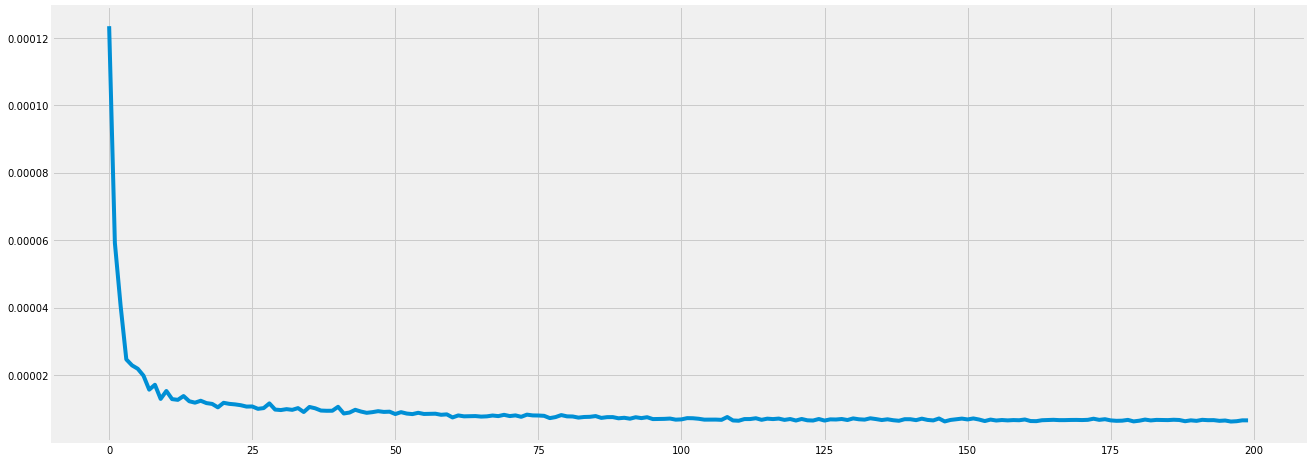

In [80]:
plt.figure(figsize=[20,8])
plt.plot(history.history['loss'])

In [84]:
print(np.argmin(history.history['loss']))

196


In [85]:
training_len = int(len(df) * 0.8)

yhigh_test = df['High'].to_numpy()[training_len:]

In [86]:
train_predict = model.predict(high_trainX)
test_predict = model.predict(high_testX)

test_predict = scaler.fit(df['High'].to_numpy().reshape(-1, 1)).inverse_transform(test_predict)

print(f"The Root Mean Square Error of the test data is: %.2f" % rmse(test_predict.flatten(), yhigh_test))

40/40 [==============================] - 0s 11ms/step
The Root Mean Square Error of the test data is: 86.63


In [90]:
test_pred_ser = pd.Series(test_predict.flatten(), index=df['High'][training_len:].index)

<AxesSubplot:>

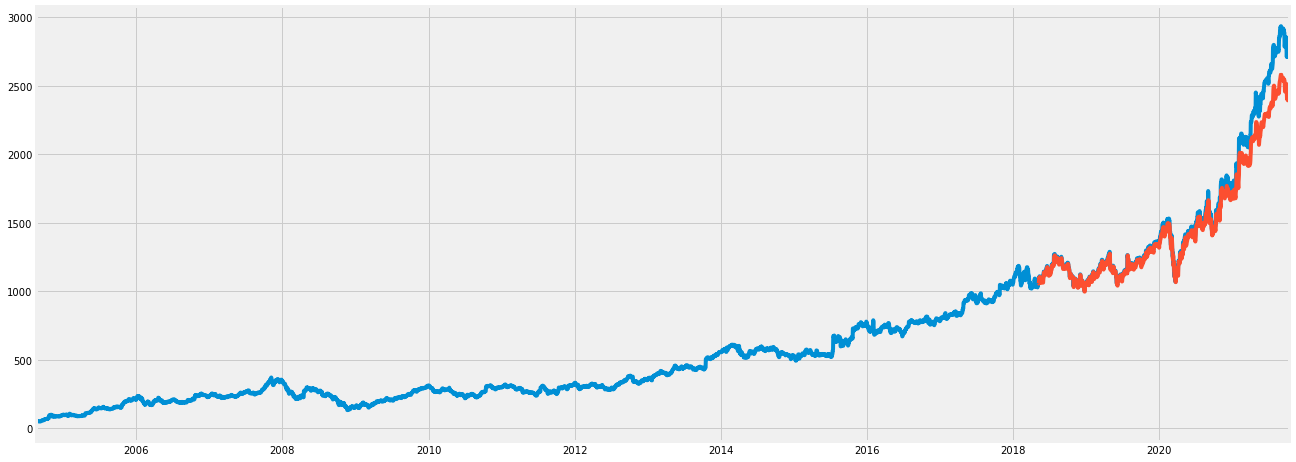

In [87]:
ax = df['High'].plot(figsize=(20,8))
test_pred_ser.plot()

<AxesSubplot:>

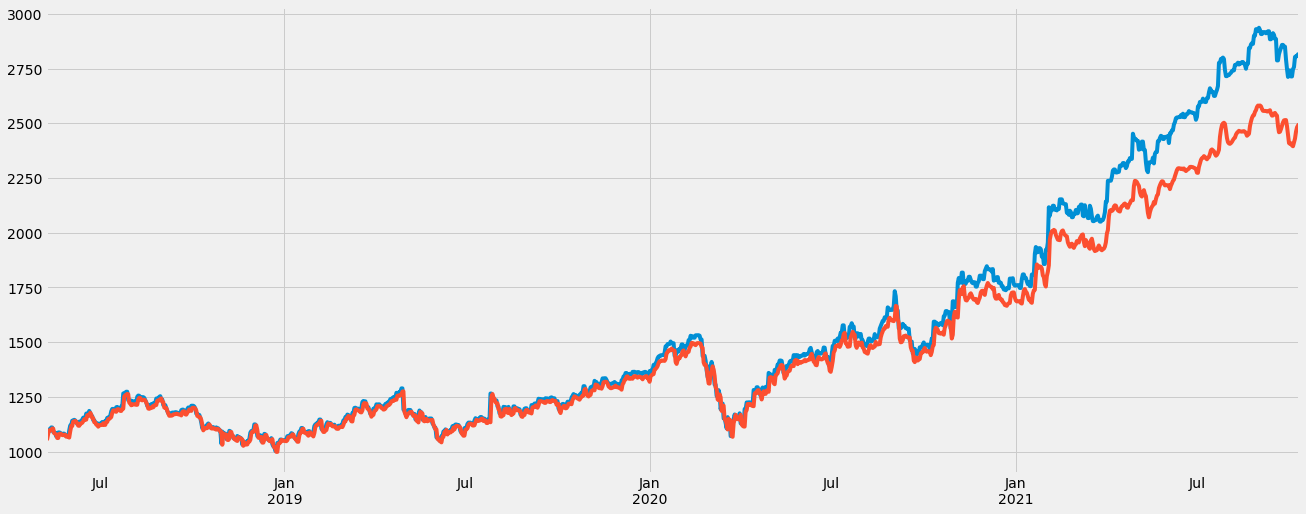

In [60]:
ax = df['High'][training_len:].plot(figsize=(20,8))
test_pred_ser.plot(ax=ax)

<AxesSubplot:>

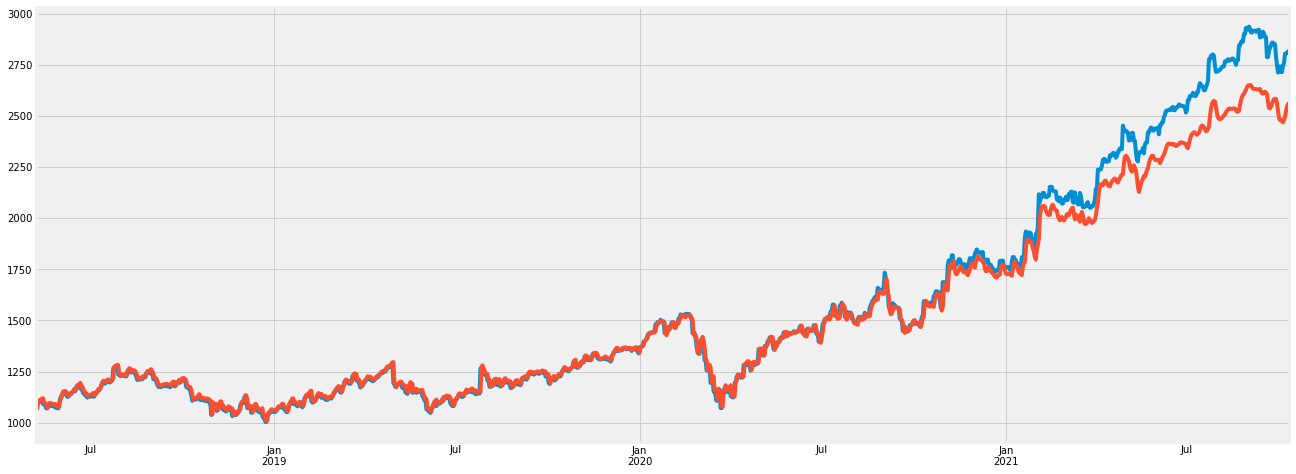

In [91]:
ax = df['High'][training_len:].plot(figsize=(20,8))
test_pred_ser.plot(ax=ax)

In [175]:
# predicting future values of the stock price

def predict_future_price(num_days=1, col='High'):
    pred_norm_values = []
    df_ = df.copy()
    scaler = MinMaxScaler()
    df_[col] = scaler.fit_transform(df[col].to_numpy().reshape(-1,1))
    training_len = int(0.8 * len(df))
    test_data = df_[col].to_numpy()[training_len:]
    
    pred_features = []
    pred_values = []
    for i in tqdm(range(num_days)):

        pred_features = test_data[-60:]
        pred_features = np.array(pred_features.reshape(1, 60, 1))
        pred_value = model.predict(pred_features, verbose=0)
        pred_values.append(pred_value.flatten()[0])
        test_data = list(test_data)
        test_data.append(pred_value.flatten()[0])
        test_data = np.array(test_data)
        
        
    pred_values = scaler.inverse_transform(np.array(pred_values).flatten().reshape(-1, 1)).ravel()
    return pred_values

In [176]:
predict_future_price()

  0%|          | 0/1 [00:00<?, ?it/s]

array([2567.773], dtype=float32)

In [178]:
predict_future_price(num_days=365)

  0%|          | 0/365 [00:00<?, ?it/s]

array([2567.773  , 2462.204  , 2314.9124 , 2144.645  , 1950.6727 ,
       1733.4121 , 1497.2053 , 1253.7312 , 1024.8767 ,  837.31885,
        707.90326,  635.6404 ,  607.7509 ,  609.8324 ,  631.2491 ,
        665.5617 ,  708.9765 ,  758.846  ,  812.77814,  868.2663 ,
        922.69684,  973.6116 , 1019.0343 , 1057.6785 , 1088.9728 ,
       1112.9553 , 1130.117  , 1141.2484 , 1147.3138 , 1149.3516 ,
       1148.4009 , 1145.4476 , 1141.3872 , 1136.9967 , 1132.9224 ,
       1129.6687 , 1127.6006 , 1126.9484 , 1127.8198 , 1130.2203 ,
       1134.0735 , 1139.2399 , 1145.5394 , 1152.771  , 1160.7266 ,
       1169.2046 , 1178.0193 , 1187.0061 , 1196.0258 , 1204.9661 ,
       1213.7415 , 1222.29   , 1230.5714 , 1238.5648 , 1246.2648 ,
       1253.6782 , 1260.8218 , 1267.7181 , 1274.3937 , 1280.877  ,
       1287.1964 , 1293.3679 , 1299.4083 , 1305.3248 , 1311.119  ,
       1316.785  , 1322.3138 , 1327.6934 , 1332.9098 , 1337.9498 ,
       1342.8018 , 1347.4581 , 1351.9152 , 1356.1722 , 1360.23